In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

import random
import cv2
import sys
import gc
import os
import time
import warnings

from sklearn.metrics import accuracy_score, confusion_matrix


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable, detect_anomaly
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid

from PIL import Image, ImageOps, ImageEnhance

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
# train_size = len(os.listdir("train/"))
# test_size = len(os.listdir("test/"))
train_size = len(os.listdir("data/train/"))
test_size = len(os.listdir("data/test/"))
print(f"学習データの枚数: {train_size}")
print(f"テストデータの枚数: {test_size}")

学習データの枚数: 60000
テストデータの枚数: 10000


In [5]:
seeds = 777
torch.manual_seed(seeds)
random.seed(seeds)
np.random.seed(seeds)
torch.cuda.manual_seed(seeds)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# 適当な画像を確認

In [6]:
image = Image.open(os.path.join('data/train', 'train_0.jpg'))
print('width, height:', image.size)
image

width, height: (28, 28)


In [7]:
image = Image.open(os.path.join('data/train', 'train_12.jpg'))
print('width, height:', image.size)
image

width, height: (28, 28)


In [8]:
image = Image.open(os.path.join('data/test', 'test_0.jpg'))
print('width, height:', image.size)
image

width, height: (28, 28)


それぞれ画像の大きさは横×縦が28×28で, グレースケール画像であることが確認できました.

学習用画像データにおけるそれぞれの数字の分布をみてみます.

In [9]:
train_master = pd.read_csv("/Users/shingo.takagi.j7a/Documents/workspace/sandbox/jupyter-nb-sandbox/signate/mnist/csv/train_master.csv")
train_master.head()

,file_name,category_id
0,train_0.jpg,5
1,train_1.jpg,0
2,train_2.jpg,4
3,train_3.jpg,1
4,train_4.jpg,9


In [10]:
train_master['category_id'].value_counts().sort_index()

category_id
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
Name: count, dtype: int64

# 手法
次に実際にモデリングを行い, 評価用画像データに対して予測をできるようにします.
今回は7層の比較的浅い畳み込みニューラルネットワークモデル(LeNet[1])によりモデリングを試みます.

実装はpytorchを用います.

まず60,000枚の学習用画像データを読み込みます. その際, あらかじめデータの数値の範囲が[0, 1]となるように正規化しておきます.

pytorchではモデルに学習データを渡す際は(サンプル数, チャンネル数, 縦, 横)の形でなければならないので, そのように変形しておきます.

# DataLoader

In [11]:
class MNIST_data(Dataset):
    """MNIST dtaa set"""

    def __init__(self, data, mode, transform=None):

        self.df = data
        self.tsfm = transform
        self.mode = mode

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name, label = self.df.loc[idx, "file_name"], self.df.loc[idx, "category_id"]
        if self.mode == "train":
            image = cv2.imread(f"data/{self.mode}/{image_name}", cv2.IMREAD_GRAYSCALE)
            label = torch.tensor(label)
            if self.tsfm != None:
                image = self.tsfm(image.astype(dtype=np.uint8))
            else:
                image = torch.FloatTensor(image)

        else:
            image = cv2.imread(f"data/{self.mode}/{image_name}", cv2.IMREAD_GRAYSCALE)
            label = torch.tensor(label)
            if self.tsfm != None:
                image = self.tsfm(image.astype(dtype=np.uint8))
            else:
                image = torch.FloatTensor(image)

        return image, label


In [12]:
transform_train = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize([0.5], [0.5])])
transform_test = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize([0.5], [0.5])])

In [13]:
sample = MNIST_data(train_master, mode="train", transform=transform_train)
sample_loader = torch.utils.data.DataLoader(dataset=sample, batch_size=16, shuffle=True, worker_init_fn=seeds)

確認

In [14]:
images, labels = next(iter(sample_loader))

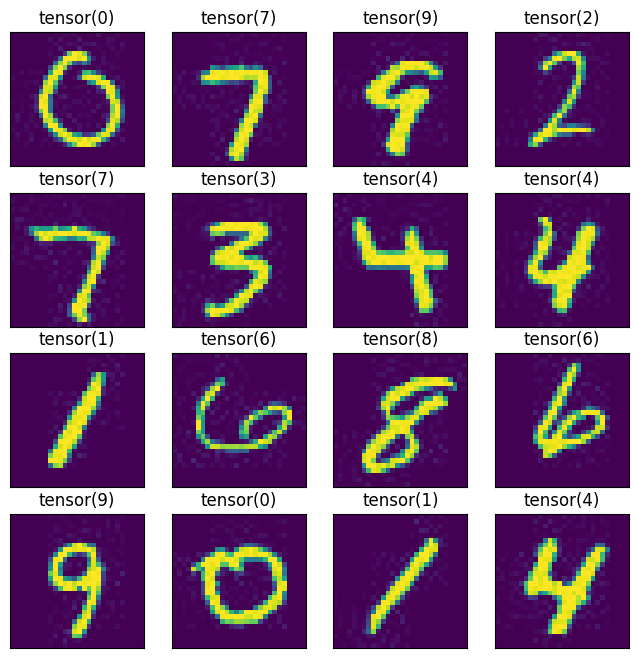

In [15]:
plt.figure(figsize=(8,8))
for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4,i+1)
    plt.imshow(image.permute(1,2,0))
    plt.title(label)
    plt.xticks(())
    plt.yticks(())
plt.show()

# Model作成&損失関数設定

In [41]:
class ModernCNN(nn.Module):
    def __init__(self, output_size=10):
        super(ModernCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(2, 2)
        # Dropoutを削除または大幅に削減
        # self.dropout = nn.Dropout(0.25)  # 削除
        self.dropout = nn.Dropout(0.1)  # または0.1に削減
        
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, output_size)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        # x = self.dropout(x)  # 削除
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        # x = self.dropout(x)  # 削除
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        return x

In [42]:
# 使用するモデルを選択
# model = LeNet(output_size=10, activation='tanh')
model = ModernCNN(output_size=10)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [43]:
# モデルのパラメータ数を計算する関数
def count_parameters(model):
    """モデルの総パラメータ数と訓練可能なパラメータ数を計算"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

def print_model_summary(model, model_name):
    """モデルのサマリーを表示"""
    total, trainable = count_parameters(model)
    print(f"\n{'='*60}")
    print(f"{model_name} のパラメータ数")
    print(f"{'='*60}")
    print(f"総パラメータ数:       {total:,}")
    print(f"訓練可能パラメータ数: {trainable:,}")
    print(f"{'='*60}\n")
    return total, trainable

def print_layer_details(model, model_name):
    """各レイヤーのパラメータ数を詳細表示"""
    print(f"\n{'='*80}")
    print(f"{model_name} - レイヤー別パラメータ詳細")
    print(f"{'='*80}")
    print(f"{'Layer Name':<40} {'Parameters':>15} {'Shape':<20}")
    print(f"{'-'*80}")
    
    total = 0
    for name, param in model.named_parameters():
        param_count = param.numel()
        total += param_count
        shape_str = str(list(param.shape))
        print(f"{name:<40} {param_count:>15,} {shape_str:<20}")
    
    print(f"{'-'*80}")
    print(f"{'Total':<40} {total:>15,}")
    print(f"{'='*80}\n")

# 両方のモデルを作成して比較
lenet_model = LeNet(output_size=10, activation='tanh')
modern_model = ModernCNN(output_size=10)

lenet_total, _ = print_model_summary(lenet_model, "LeNet (オリジナル)")
modern_total, _ = print_model_summary(modern_model, "ModernCNN (改善版)")

# 比較結果
print(f"\n{'='*60}")
print("パラメータ数の比較")
print(f"{'='*60}")
print(f"LeNet:      {lenet_total:,} パラメータ")
print(f"ModernCNN:  {modern_total:,} パラメータ")
reduction_ratio = (1 - modern_total / lenet_total) * 100
if modern_total < lenet_total:
    print(f"\n削減率:     {reduction_ratio:.1f}% 削減")
    print(f"削減数:     {lenet_total - modern_total:,} パラメータ削減")
else:
    increase_ratio = (modern_total / lenet_total - 1) * 100
    print(f"\n増加率:     {increase_ratio:.1f}% 増加")
    print(f"増加数:     {modern_total - lenet_total:,} パラメータ増加")
print(f"{'='*60}")

# レイヤーごとの詳細を表示
print_layer_details(lenet_model, "LeNet (オリジナル)")
print_layer_details(modern_model, "ModernCNN (改善版)")


LeNet (オリジナル) のパラメータ数
総パラメータ数:       44,426
訓練可能パラメータ数: 44,426


ModernCNN (改善版) のパラメータ数
総パラメータ数:       56,714
訓練可能パラメータ数: 56,714


パラメータ数の比較
LeNet:      44,426 パラメータ
ModernCNN:  56,714 パラメータ

増加率:     27.7% 増加
増加数:     12,288 パラメータ増加

LeNet (オリジナル) - レイヤー別パラメータ詳細
Layer Name                                    Parameters Shape               
--------------------------------------------------------------------------------
conv1.weight                                         150 [6, 1, 5, 5]        
conv1.bias                                             6 [6]                 
conv2.weight                                       2,400 [16, 6, 5, 5]       
conv2.bias                                            16 [16]                
fc1.weight                                        30,720 [120, 256]          
fc1.bias                                             120 [120]               
fc2.weight                                        10,080 [84, 120]           
fc2.bias                     

# 訓練

In [44]:
#GPUを使うか使わないか(使う場合cudaになり、使わない場合cpuとなる)
device = ""

if torch.cuda.is_available():
    device = "cuda"

if torch.backends.mps.is_available():
    device = "mps"

if device == "":
    device = "cpu"

In [45]:
model = model.to(device)

In [46]:
train, valid, _, _ = train_test_split(train_master, train_master["category_id"], test_size=0.25, random_state=seeds)
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

In [47]:
batch_size = 64
train_data = MNIST_data(train, mode="train", transform=transform_train)
valid_data = MNIST_data(valid, mode="train", transform=transform_test)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, worker_init_fn=seeds)
valid_loader = torch.utils.data.DataLoader(dataset=valid_data, batch_size=batch_size)

In [48]:
EPOCH = 4
total_batch = int(len(train_loader)/12)

In [49]:
# 学習→検証までの関数
def training_validation(input_model, EPOCH, training_data, validation_data, num_update):
    total_batch = int(len(training_data)/num_update)
    
    # 履歴を記録するリスト
    history = {
        'train_loss': [],
        'valid_loss': [],
        'valid_accuracy': []
    }
    
    for epoch in range(1, EPOCH+1):
        input_model.train()
        #訓練プロセス
        train_loss = []
        pbar = tqdm.tqdm(enumerate(training_data), total = len(training_data))
        for process, (images, labels) in pbar:
            images = images.to(device)
            labels = labels.to(device)
            time_1 = time.time()
            outputs = input_model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss = loss.item()
            train_loss.append(loss)
            if (process % total_batch == 0) | (process == len(training_data)):
                pbar.set_postfix(EPOCH=epoch, train_loss=np.mean(train_loss))

        #検証プロセス
        input_model.eval()
        valid_loss = []
        correct = 0
        valid_time = time.time()
        for process, (images, labels) in enumerate(validation_data):
            images = images.to(device)
            labels = labels.to(device)
            outputs = input_model(images)
            loss = criterion(outputs, labels)
            loss = loss.item()
            valid_loss.append(loss)
            pred = outputs.data.max(1, keepdim=True)[1]
            correct += pred.eq(labels.data.view_as(pred)).cpu().sum().item()
        minute, second = int((time.time()-valid_time)//59), int((time.time()-valid_time)%60)
        
        # エポックごとの結果を記録
        epoch_train_loss = np.mean(train_loss)
        epoch_valid_loss = np.mean(valid_loss)
        epoch_valid_accuracy = correct/len(validation_data.dataset)
        
        history['train_loss'].append(epoch_train_loss)
        history['valid_loss'].append(epoch_valid_loss)
        history['valid_accuracy'].append(epoch_valid_accuracy)
        
        pbar.set_postfix(EPOCH=epoch, train_loss=epoch_train_loss, valid_loss=epoch_valid_loss, valid_accuracy=epoch_valid_accuracy)
        print(f"valid_loss: {epoch_valid_loss}, valid_accuracy: {epoch_valid_accuracy}")

    return_model = input_model

    return return_model, history

In [50]:
# 予測結果のそれぞれの誤差の大きさを確認
def predict_img(input_model, input_data):
    input_model.eval()
    test_pred = torch.LongTensor()
    test_proba = torch.FloatTensor()
    for images, labels in tqdm.tqdm(input_data):
        images = images.to(device)
        labels = labels.to(device)
        outputs = input_model(images)
        pred_proba = F.softmax(outputs, dim=1).cpu()
        pred = outputs.data.max(1, keepdim=True)[1].view(-1)
        pred = torch.stack([labels,pred],axis=1).cpu()
        test_pred = torch.cat((test_pred, pred), dim=0)
        test_proba = torch.cat((test_proba, pred_proba), dim=0)
    test_pred = test_pred.cpu().detach().numpy()
    test_proba = test_proba.cpu().detach().numpy()
    loss_correct = np.array(pd.get_dummies(test_pred[:,0]))
    test_loss = -(loss_correct*np.log(test_proba+1e-07)).sum(axis=1)
    test_pred = pd.DataFrame(test_pred).rename(columns = {0:"label" ,1:"predict"})
    test_proba = pd.DataFrame(test_proba).rename(columns = {0:"proba_0", 1:"proba_1", 2:"proba_2", 3:"proba_3", 4:"proba_4",
                                                            5:"proba_5", 6:"proba_6", 7:"proba_7", 8:"proba_8", 9:"proba_9"})
    test_loss = pd.DataFrame(test_loss).rename(columns = {0:"loss"})
    df = pd.concat([test_pred, test_proba, test_loss], axis=1)
    del loss_correct
    gc.collect()
    return df

LeNetモデルを学習させてみます.

In [51]:
model, history = training_validation(model, EPOCH, train_loader, valid_loader, 12)

  0%|          | 0/704 [00:00<?, ?it/s]

100%|██████████| 704/704 [02:03<00:00,  5.71it/s, EPOCH=1, train_loss=1.78]


valid_loss: 1.3420995960844324, valid_accuracy: 0.6871333333333334


100%|██████████| 704/704 [02:36<00:00,  4.50it/s, EPOCH=2, train_loss=1.01]


valid_loss: 0.7656421681667896, valid_accuracy: 0.8374666666666667


100%|██████████| 704/704 [01:39<00:00,  7.05it/s, EPOCH=3, train_loss=0.549]


valid_loss: 0.42984008928562734, valid_accuracy: 0.925


100%|██████████| 704/704 [01:28<00:00,  7.97it/s, EPOCH=4, train_loss=0.342]


valid_loss: 0.35906275269833016, valid_accuracy: 0.9192


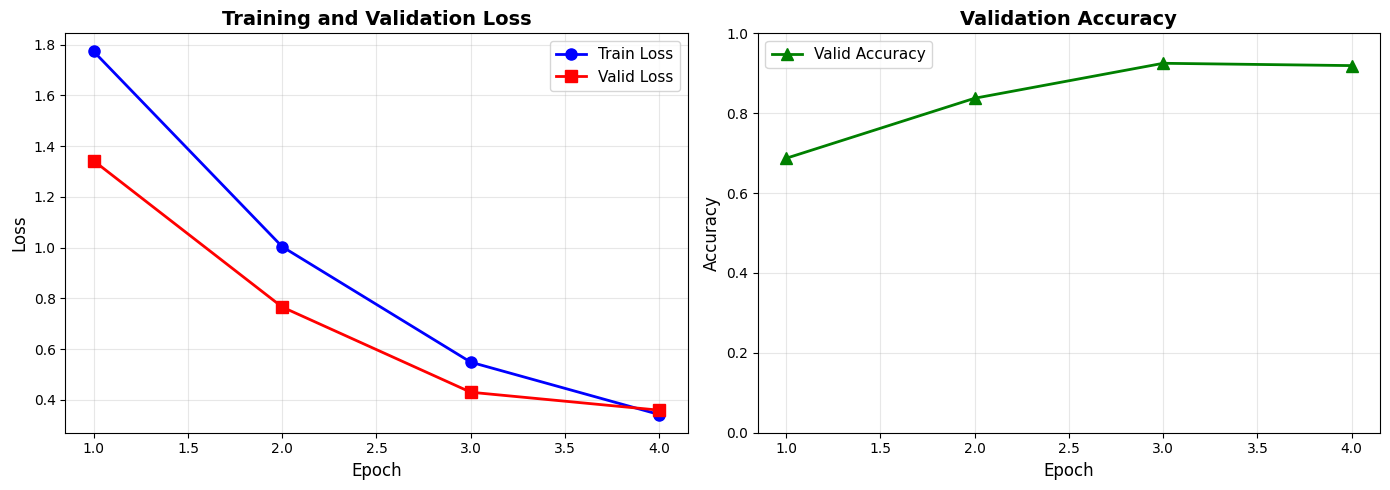


=== 学習結果サマリー ===
最終訓練損失: 0.3418
最終検証損失: 0.3591
最終検証精度: 0.9192
最良検証精度: 0.9250 (Epoch 3)


In [52]:
# 学習過程の可視化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 損失の推移
epochs = range(1, len(history['train_loss']) + 1)
ax1.plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=8)
ax1.plot(epochs, history['valid_loss'], 'r-s', label='Valid Loss', linewidth=2, markersize=8)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# 精度の推移
ax2.plot(epochs, history['valid_accuracy'], 'g-^', label='Valid Accuracy', linewidth=2, markersize=8)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.show()

# 最終結果の表示
print("\n=== 学習結果サマリー ===")
print(f"最終訓練損失: {history['train_loss'][-1]:.4f}")
print(f"最終検証損失: {history['valid_loss'][-1]:.4f}")
print(f"最終検証精度: {history['valid_accuracy'][-1]:.4f}")
print(f"最良検証精度: {max(history['valid_accuracy']):.4f} (Epoch {history['valid_accuracy'].index(max(history['valid_accuracy'])) + 1})")

学習済みモデルの予測結果を確認

In [53]:
predict_df = predict_img(model, valid_loader)

100%|██████████| 235/235 [00:13<00:00, 17.61it/s]


混合行列でLeNetのそれぞれの数字の精度を確認

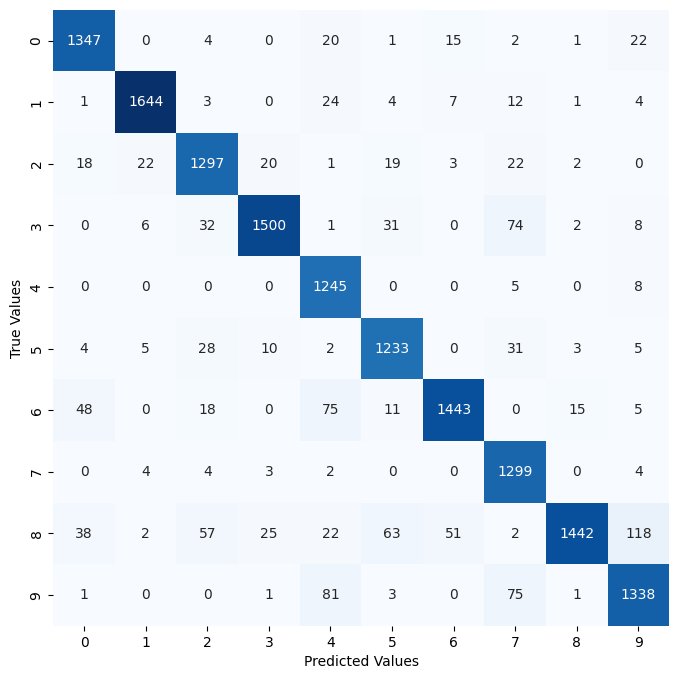

In [54]:
plt.figure(figsize=(8,8))
mat = confusion_matrix(predict_df["label"], predict_df["predict"]) # Confusion matrix
# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt="d")
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

間違えた予測の一覧を確認します

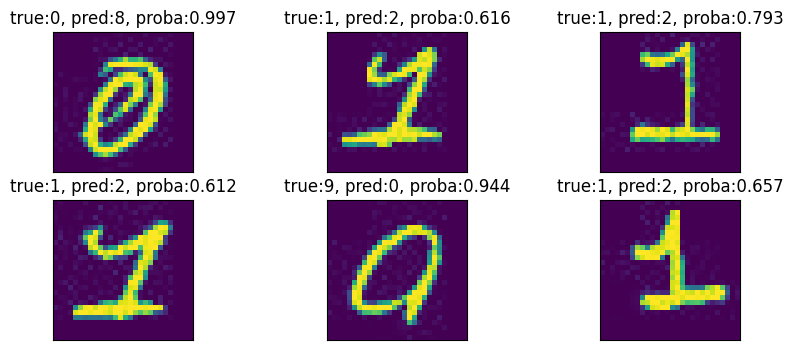

In [55]:
# 大きく間違えた予測
error_index = predict_df[predict_df["label"] != predict_df["predict"]].sort_values(by="loss",ascending=False).head(6).index
plt.figure(figsize=(10,4))
for i, ind in enumerate(error_index):
    label = int(predict_df.iloc[ind]["label"])
    pred = int(predict_df.iloc[ind]["predict"])
    proba = predict_df.iloc[ind]["proba_"+str(pred)]

    image_name = valid.reset_index(drop=True).loc[ind, "file_name"]
    image = cv2.imread(f"data/train/{image_name}", cv2.IMREAD_GRAYSCALE)
    plt.subplot(2,3,i+1)
    plt.imshow(image)
    plt.title("true:{}, pred:{}, proba:{}".format(label, pred, proba.round(3)))
    plt.xticks(())
    plt.yticks(())
plt.show()

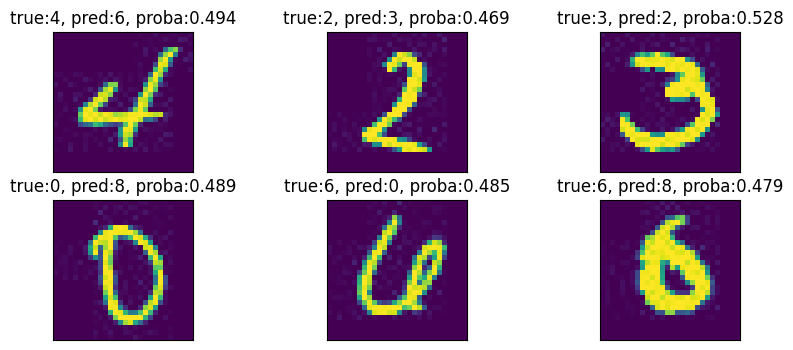

In [56]:
# 惜しい予測
error_index = predict_df[predict_df["label"] != predict_df["predict"]].sort_values(by="loss",ascending=False).tail(6).index
plt.figure(figsize=(10,4))
for i, ind in enumerate(error_index):
    label = int(predict_df.iloc[ind]["label"])
    pred = int(predict_df.iloc[ind]["predict"])
    proba = predict_df.iloc[ind]["proba_"+str(pred)]

    image_name = valid.reset_index(drop=True).loc[ind, "file_name"]
    image = cv2.imread(f"data/train/{image_name}", cv2.IMREAD_GRAYSCALE)
    plt.subplot(2,3,i+1)
    plt.imshow(image)
    plt.title("true:{}, pred:{}, proba:{}".format(label, pred, proba.round(3)))
    plt.xticks(())
    plt.yticks(())
plt.show()

評価用画像データに対して予測値を出力する関数を実装します.

In [57]:
submit = pd.read_csv("/Users/shingo.takagi.j7a/Documents/workspace/sandbox/jupyter-nb-sandbox/signate/mnist/csv/sample_submit.csv", header=None)
submit.head()

,0,1
0,test_0.jpg,2
1,test_1.jpg,4
2,test_2.jpg,5
3,test_3.jpg,4
4,test_4.jpg,3


In [58]:
# DataSetの形式に合わせるため、ヘッダを少し変更
submit.columns = ["file_name", "category_id"]

In [59]:
test_data = MNIST_data(submit, mode="test", transform=transform_test)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size)

In [60]:
def model_predict(input_model, input_data):
    input_model.eval()
    test_pred = torch.LongTensor()
    for data, _ in tqdm.tqdm(input_data):
        data = data.to(device)
        output = model(data)
        pred = output.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)
    return test_pred

In [61]:
predict = model_predict(model, test_loader)

100%|██████████| 157/157 [00:30<00:00,  5.15it/s]


In [62]:
predict = predict.cpu().detach().numpy().reshape(-1).copy()

In [63]:
submit["category_id"] = predict

In [64]:
submit.head()

,file_name,category_id
0,test_0.jpg,7
1,test_1.jpg,2
2,test_2.jpg,1
3,test_3.jpg,0
4,test_4.jpg,4


In [65]:
submit.to_csv('/Users/shingo.takagi.j7a/Documents/workspace/sandbox/jupyter-nb-sandbox/signate/mnist/csv/submission.csv', index=False, header=None)

# 評価

tutorial_submission.csv(LeNet(tanh))を投稿すると, 0.9163ほどとなります.

# まとめ

今回は比較的浅いネットワークモデルであるLeNetを適用して, 90%の正解率を出すことがわかりました.

他にも活性化関数の変更などで精度がどのように変わるか確認してみてください.`activation='tanh'`を`relu`に変更すると、reluで分析することができます.

LeNetは初期の深層学習モデルのため、その後様々な新しい深層学習モデルが提案されているので, 色々試してみると精度に違いが見えると思います.

その他色々工夫をしてさらなる改善を目指してみてください.

# 参考文献

[1] Y. LeCun, L. Bottou, Y. Bengio and P. Haffner: Gradient-Based Learning Applied to Document Recognition, Proceedings of the IEEE, 86(11):2278-2324, November 1998
